# Business Context

Customer lifetime value (CLV) is the total worth of a customer to a company over the length of their relationship. In practice, this “worth” can be defined as revenue, profit, or other metrics of an analyst’s choosing.


CLV is an important metric to track for two reasons. First, the totality of a company’s CLV over its entire customer base gives a rough idea of its market value. Thus, a company with a high total CLV will appear attractive to investors. Second, a CLV analysis can guide the formulation of customer acquisition and retention strategies. For example, special attention could be given to high-value customers to ensure that they stay loyal to the company.


Many CLV models have been developed with different levels of sophistication and accuracy, ranging from rough heuristics to the use of complex probabilistic frameworks. In this blog post series, we delve into one of them: the Beta Geometric Negative Binomial Distribution (BG-NBD) model. This model, developed by Fader, Hardie, and Lee in 2005¹, has been one of the most influential models in the domain, thanks to its interpretability and accuracy.

Intuition about the model can be found in the following [article](https://medium.com/p/d5111cb52dd).

# Lifetimes

In this section, we will explore the use of the `lifetimes` [library](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#basic-frequency-recency-analysis-using-the-bg-nbd-model)

## Data Load

In [1]:
import pandas as pd
from lifetimes.datasets import load_dataset

transactions = load_dataset(
    filename='CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)

transactions.head(3)

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96


In [2]:
transactions["customer_id"].nunique()

2357

In [3]:
len(transactions)

6919

In [4]:
transactions["date"].describe()

count                    6919
unique                    545
top       1997-03-24 00:00:00
freq                       60
first     1997-01-01 00:00:00
last      1998-06-30 00:00:00
Name: date, dtype: object

## Data Transformation to RFM format

In [5]:
from lifetimes.utils import summary_data_from_transaction_data

rfm = summary_data_from_transaction_data(transactions=transactions,
                                         customer_id_col='customer_id',
                                         datetime_col='date',
                                         monetary_value_col = 'amount',
                                         observation_period_end=pd.to_datetime('1998-06-30'),
                                         freq='W')

rfm.head(3)

,frequency,recency,T,monetary_value
customer_id,,,,
4,3.0,49.0,78.0,23.723333
18,0.0,0.0,78.0,0.000000
21,1.0,2.0,78.0,11.770000


## Train-test split (calibration/observation split)

In [6]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions=transactions,
                                               customer_id_col='customer_id', 
                                               datetime_col='date',
                                               monetary_value_col = 'amount',
                                               freq='W',
                                               calibration_period_end='1998-01-01',
                                               observation_period_end='1998-06-30' )

rfm_cal_holdout.head(3)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.0,26.0
18,0.0,0.0,52.0,0.000000,0.0,0.0,26.0
21,1.0,2.0,52.0,11.770000,0.0,0.0,26.0


## Model fit

In [7]:
from lifetimes import BetaGeoFitter

# instantiation of BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fitting of BG-NBD model
bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], 
        recency=rfm_cal_holdout['recency_cal'], 
        T=rfm_cal_holdout['T_cal'])

# printing of model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.281847,0.014034,0.254340,0.309354
alpha,6.732810,0.532304,5.689494,7.776126
a,0.532360,0.122632,0.292000,0.772719
b,1.971260,0.575322,0.843628,3.098892


- do train test split and analysis of the test set
- derive business sense

## Model analysis

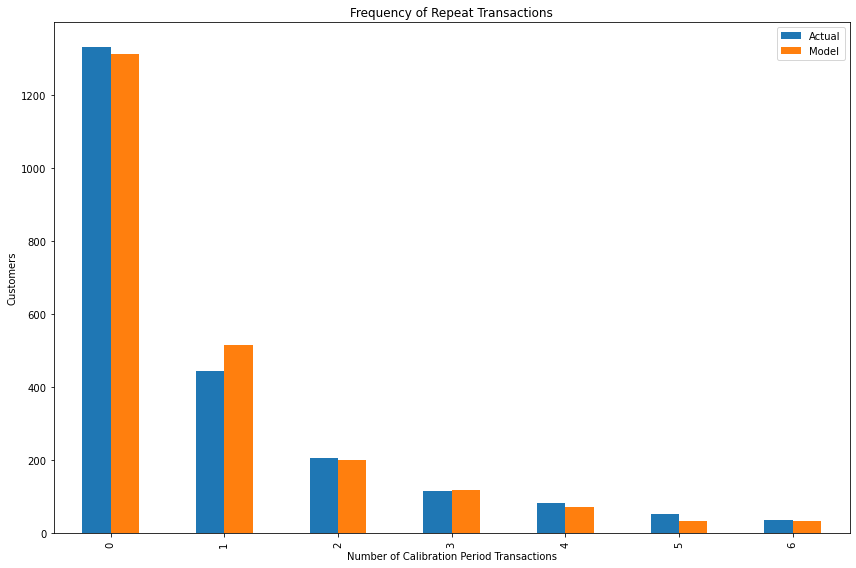

In [8]:
from lifetimes.plotting import plot_period_transactions
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True

_ = plot_period_transactions(bgf) # returns a matplotlib axis object

## Model prediction

In [9]:
# First, we choose a sample customer. 
sample_customer = rfm_cal_holdout.iloc[20] 

# Let's inspect his frequency, recency and T both for the calibration and observation periods:
sample_customer

frequency_cal              3.000000
recency_cal               28.000000
T_cal                     52.000000
monetary_value_cal        25.076667
frequency_holdout          2.000000
monetary_value_holdout    29.480000
duration_holdout          26.000000
Name: 226, dtype: float64

In [10]:
# This function calculates the conditional expected number of transactions in the given time length
bgf.predict(t=26, # we set it to 26 weeks (the length of the observation period)
            frequency=sample_customer['frequency_cal'], 
            recency=sample_customer['recency_cal'], 
            T=sample_customer['T_cal'])

0.7647440846242359

In [11]:
bgf.conditional_probability_alive(frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])

array([0.57089896])

In [12]:
# the real number of transactions in the observation period, which equals frequency_holdout + 1
rfm_cal_holdout["n_transactions_holdout_real"]  = rfm_cal_holdout["frequency_holdout"] + 1

# the predicted number of transactions
rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=26, 
                                                    frequency=rfm_cal_holdout['frequency_cal'], 
                                                    recency=rfm_cal_holdout['recency_cal'], 
                                                    T=rfm_cal_holdout['T_cal'])

# comparison
rfm_cal_holdout[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].head()

,n_transactions_holdout_real,n_transactions_holdout_pred
customer_id,,
4,1.0,1.155554
18,1.0,0.118167
21,1.0,0.128974
50,1.0,0.118167
60,1.0,0.126350


In [13]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_true = rfm_cal_holdout["n_transactions_holdout_real"],
                          y_pred = rfm_cal_holdout["n_transactions_holdout_pred"],
                          squared = False)

RMSE # = 1.3536793286521

1.3536793286521

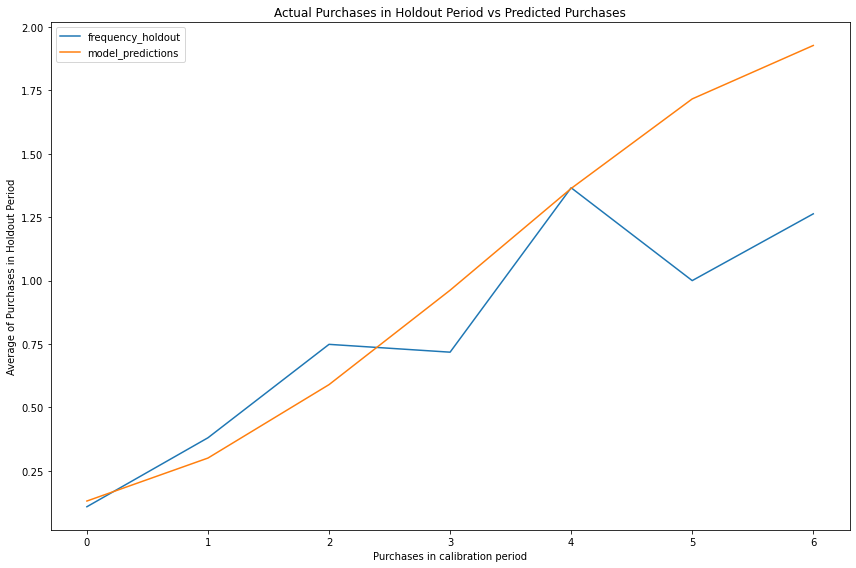

In [14]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True

_ = plot_calibration_purchases_vs_holdout_purchases(bgf, rfm_cal_holdout)

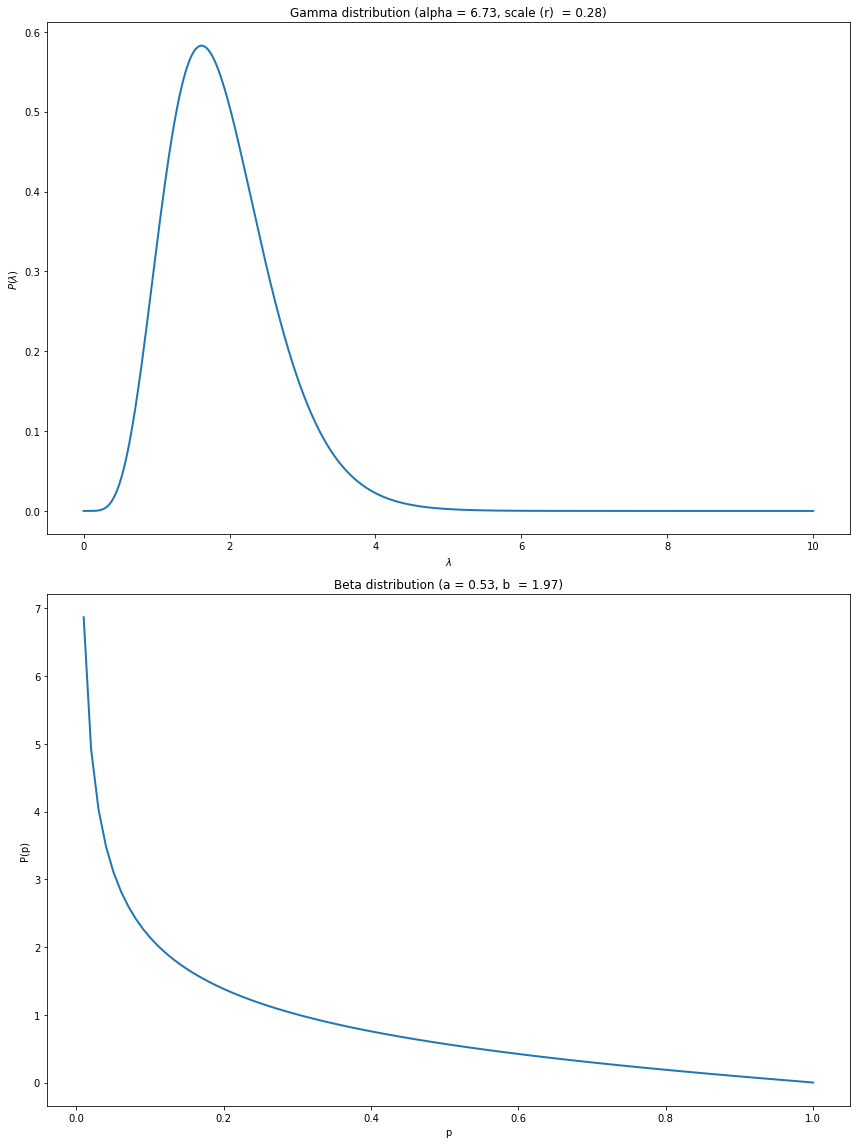

In [15]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['lines.linewidth'] = 2
rcParams['axes.titlesize'] = 'large'


fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows =2, figsize = (12, 16))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=bgf.params_["alpha"], scale=bgf.params_["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {bgf.params_["alpha"]:.2f}, scale (r)  = {bgf.params_["r"]:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')


x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf.params_["a"], b=bgf.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {bgf.params_["a"]:.2f}, b  = {bgf.params_["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()

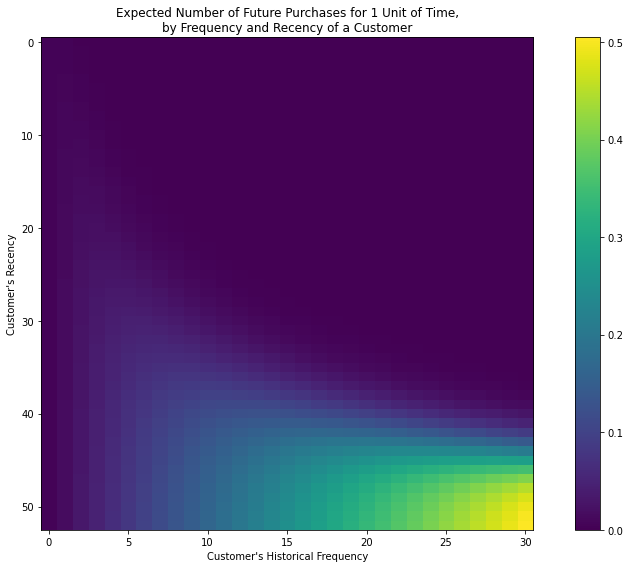

In [16]:
from lifetimes.plotting import plot_frequency_recency_matrix

plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True

_ = plot_frequency_recency_matrix(bgf)

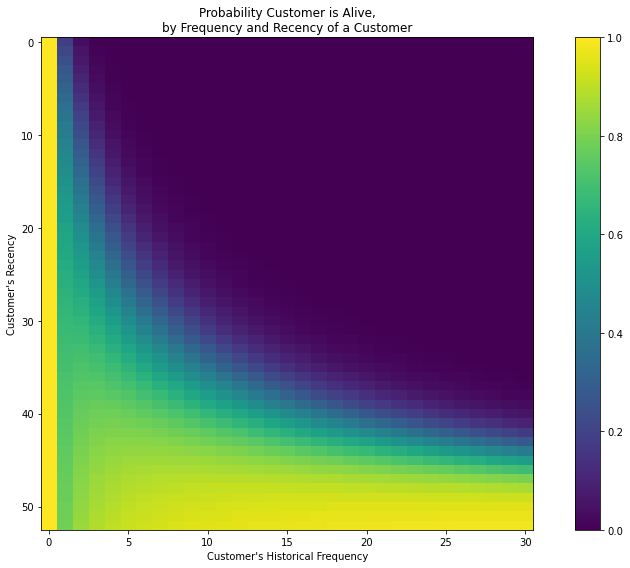

In [17]:
from lifetimes.plotting import plot_probability_alive_matrix


plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True

_ = plot_probability_alive_matrix(bgf)

## Business application

In [18]:


# the predicted number of transactions in the next 10 weeks
rfm_cal_holdout["n_transactions_10_pred"] = bgf.predict(t=10, 
                                                        frequency=rfm_cal_holdout['frequency_cal'], 
                                                        recency=rfm_cal_holdout['recency_cal'], 
                                                        T=rfm_cal_holdout['T_cal'])

# the probability of being alive
rfm_cal_holdout["alive_prob"] = bgf.conditional_probability_alive(frequency=rfm_cal_holdout['frequency_cal'], 
                                                                  recency=rfm_cal_holdout['recency_cal'], 
                                                                  T=rfm_cal_holdout['T_cal'])


# multiplication of alive probability x number of purchases x average past purchase
rfm_cal_holdout["value_10_pred"] = rfm_cal_holdout["alive_prob"]* \
                                   rfm_cal_holdout["n_transactions_10_pred"]*\
                                   rfm_cal_holdout["monetary_value_cal"]
                                   
                                     
rfm_cal_holdout[["value_10_pred", "alive_prob", "n_transactions_10_pred", "monetary_value_cal"]].head()


,value_10_pred,alive_prob,n_transactions_10_pred,monetary_value_cal
customer_id,,,,
4,9.53934,0.862647,0.466132,23.723333
18,0.00000,1.000000,0.046933,0.000000
21,0.14799,0.243428,0.051652,11.770000
50,0.00000,1.000000,0.046933,0.000000
60,0.00000,1.000000,0.050285,0.000000


In [19]:
rfm_cal_holdout["value_10_pred"].describe()

count    2357.000000
mean        5.178024
std        16.195977
min         0.000000
25%         0.000000
50%         0.000000
75%         2.453662
max       213.484909
Name: value_10_pred, dtype: float64

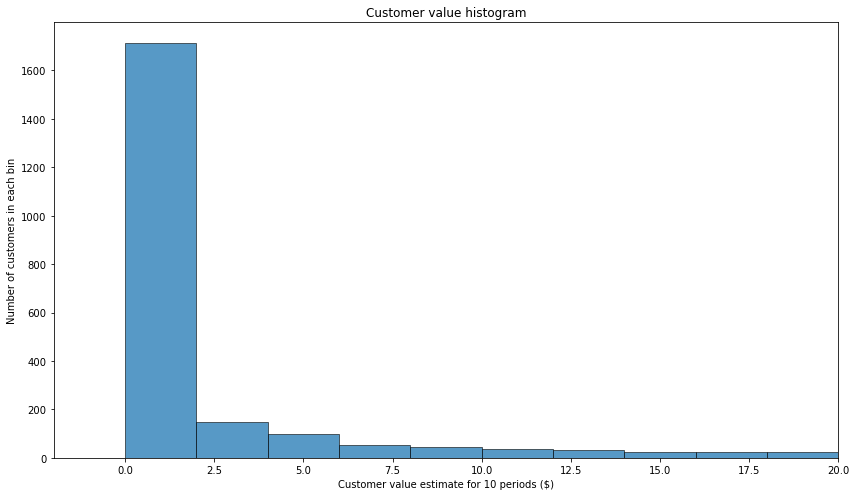

In [20]:
import seaborn as sns 

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.histplot(rfm_cal_holdout["value_10_pred"], 
                  kde=False, 
                  binwidth = 2)
ax.set_title(f'Customer value histogram')
ax.set_xlabel(r'Customer value estimate for 10 periods ($)')
ax.set_ylabel(r'Number of customers in each bin')
ax.set_xlim(-2,20)

plt.show()

In [21]:
VALUE_10_PRED_THRESHOLD = 10

# filtering for high-value customers
rfm_cal_holdout.loc[rfm_cal_holdout["value_10_pred"]>VALUE_10_PRED_THRESHOLD, 
                   ["value_10_pred"]]


,value_10_pred
customer_id,
111,94.006160
133,22.670743
166,15.338678
167,22.797245
228,43.224262
...,...
23498,30.545742
23500,11.031599
23507,21.082439


# Bayesian

### Prerequisites

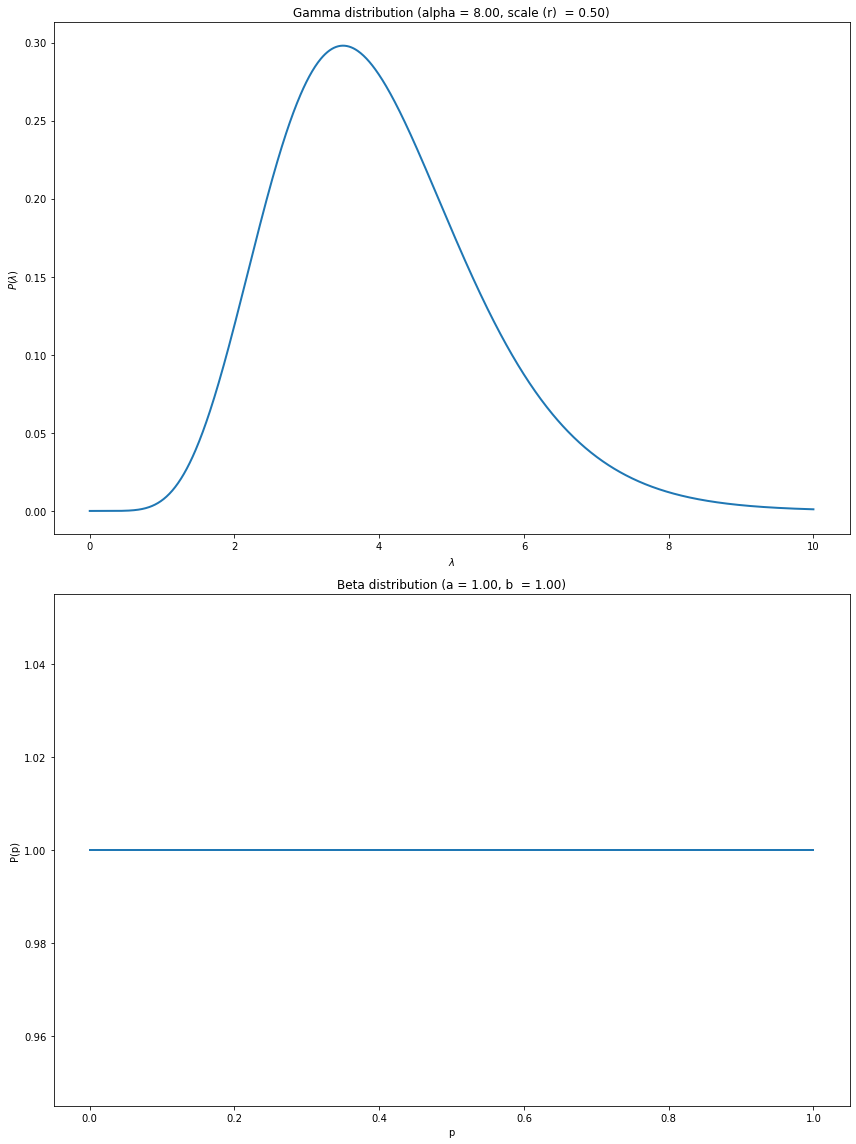

In [22]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['lines.linewidth'] = 2
rcParams['axes.titlesize'] = 'large'


fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows =2, figsize = (12, 16))

ALPHA_mean = 8
R_mean = 0.5
A_mean = 1
B_mean = 1


x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=ALPHA_mean, scale=R_mean)
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {ALPHA_mean:.2f}, scale (r)  = {R_mean:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')


x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=A_mean, b=B_mean)
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {A_mean:.2f}, b  = {B_mean:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()

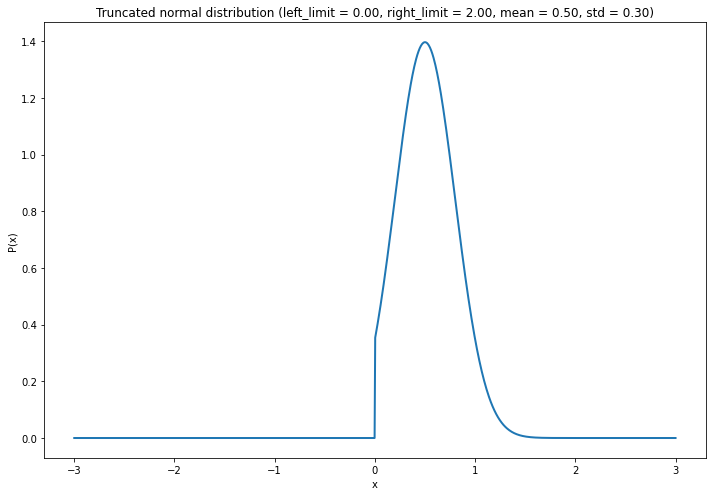

In [23]:
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

# https://docs.pymc.io/en/latest/api/distributions/generated/pymc.TruncatedNormal.html


myclip_a = 0
myclip_b = 2
my_mean = 0.5
my_std = 0.3

fig, ax = plt.subplots(ncols=1, nrows =1, figsize = (10, 7))

a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
x_range = np.linspace(-3,3,1000)
ax.plot(x_range, truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std))
ax.set_title(f'Truncated normal distribution (left_limit = {myclip_a:.2f}, right_limit = {myclip_b:.2f}, mean = {my_mean:.2f}, std = {my_std:.2f})')
ax.set_xlabel('x')
ax.set_ylabel('P(x)')
plt.show()

### PyMC3

In [36]:
from pymc3.math import log, exp, where
import pymc3 as pm
import numpy as np


# We use the "calibration" portion of the dataset to train the model
N = rfm_cal_holdout.shape[0] # number of customers
x = rfm_cal_holdout['frequency_cal'].values # repeat purchase frequency
t_x = rfm_cal_holdout['recency_cal'].values # recency
T = rfm_cal_holdout['T_cal'].values # time since first purchase (T)

# Modeling step
bgnbd_model = pm.Model()
with bgnbd_model:
    
    # Priors for r and alpha, the two Gamma parameters
    r = pm.TruncatedNormal('r', mu=8, sigma=7, lower=0, upper=40)
    alpha = pm.TruncatedNormal('alpha', mu=0.5, sigma=5, lower=0, upper=10)

    # Priors for a and b, the two Beta parameters
    a = pm.TruncatedNormal('a', mu=1, sigma=5, lower=0, upper=10)
    b = pm.TruncatedNormal('b', mu=1, sigma=5, lower=0, upper=10)

    # lambda_ (purchase rate) is modeled by Gamma, which is a child distribution of r and alpha
    lambda_ = pm.Gamma('lambda', alpha=r, beta=alpha, shape=N)
    
    # p (dropout probability) is modeled by Beta, which is a child distribution of a and b
    p = pm.Beta('p', alpha=a, beta=b, shape=N)
    
    def logp(x, t_x, T):
        """
        Loglikelihood function
        """    
        delta_x = where(x>0, 1, 0)
        A1 = x*log(1-p) + x*log(lambda_) - lambda_*T
        A2 = (log(p) + (x-1)*log(1-p) + x*log(lambda_) - lambda_*t_x)
        A3 = log(exp(A1) + delta_x * exp(A2))
        return A3
    
    # Custom distribution for BG-NBD likelihood function
    loglikelihood = pm.DensityDist("loglikelihood", logp, observed={'x': x, 't_x': t_x, 'T': T})

# Sampling step
SEED = 8 
SAMPLE_KWARGS = {
    'chains': 1,
    'draws': 4000,
    'tune': 2000,
    'target_accept': 0.8,
    'random_seed': [
        SEED,
    ]
}
with bgnbd_model:
    trace = pm.sample(**SAMPLE_KWARGS)
    
# It's a good practice to burn (discard) early samples
# these are likely to be obtained before convergence
# they aren't representative of our posteriors.
trace_trunc = trace[3000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p, lambda, b, a, alpha, r]


Sampling 1 chain for 2_000 tune and 4_000 draw iterations (2_000 + 4_000 draws total) took 402 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Analysis

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


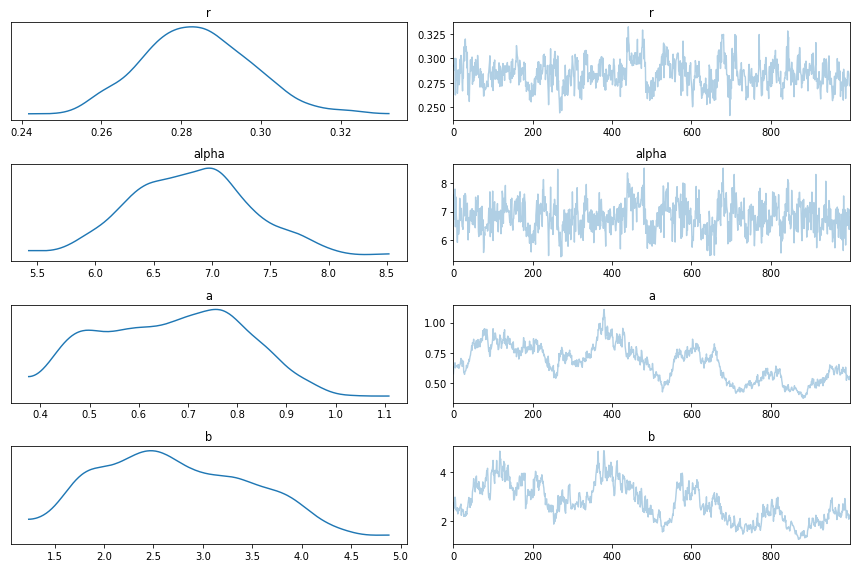

In [40]:
trace_trunc = trace[3000:]
_ = pm.plot_trace(trace_trunc, var_names = ["r", "alpha", "a", "b"], rug = False)

In [41]:
params_mean = pm.summary(trace_trunc, var_names = ["r", "alpha", "a", "b"])["mean"]
params_mean

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


r        0.284
alpha    6.817
a        0.667
b        2.736
Name: mean, dtype: float64

In [70]:
combined_summary = bgf.summary[["coef"]]
combined_summary.columns = ["lifetimes"]
combined_summary["pymc3"] = params_mean
pd.set_option("display.precision", 3)
combined_summary

,lifetimes,pymc3
r,0.282,0.284
alpha,6.733,6.817
a,0.532,0.667
b,1.971,2.736


In [56]:
sns.kdeplot(trace_trunc["r"], ax = ax)

<AxesSubplot:title={'center':'Truncated normal distribution (left_limit = 0.00, right_limit = 2.00, mean = 0.50, std = 0.30)'}, xlabel='x', ylabel='P(x)'>

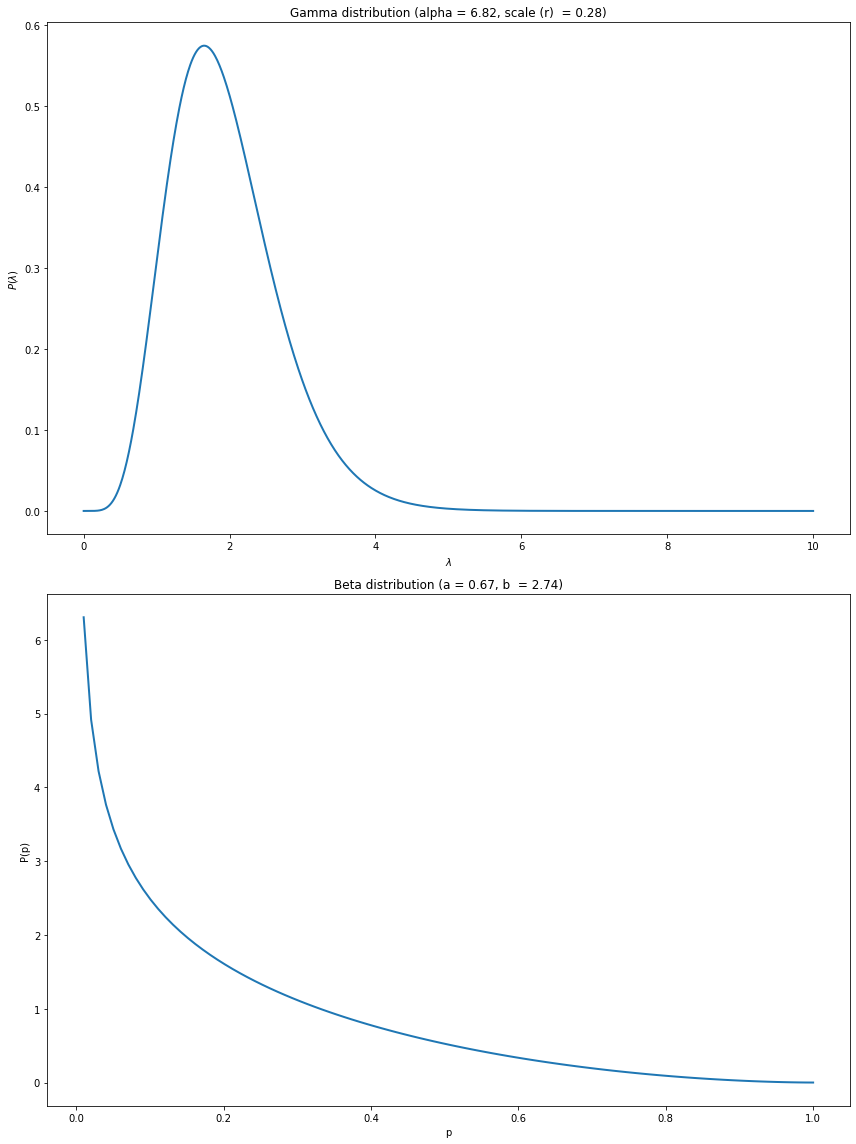

In [69]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['lines.linewidth'] = 2
rcParams['axes.titlesize'] = 'large'


fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows =2, figsize = (12, 16))


x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=params_mean["alpha"], scale=params_mean["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {params_mean["alpha"]:.2f}, scale (r)  = {params_mean["r"]:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')


x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=params_mean["a"], b=params_mean["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {params_mean["a"]:.2f}, b  = {params_mean["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()